In [8]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision

def load_image_data(image_path):
    img_data = torchvision.io.read_image(image_path)
    img_data = img_data.permute(1, 2, 0)[:, :,:3] / 255.0
    return img_data


image_data = load_image_data('image.jpg')
print(image_data.shape)
crop_dimension = 512
image_data = image_data[
    image_data.shape[0] // 2 - crop_dimension // 2 : image_data.shape[0] // 2 + crop_dimension // 2,
    image_data.shape[1] // 2 - crop_dimension // 2 : image_data.shape[1] // 2 + crop_dimension // 2,
]
print(image_data.shape)

coordinate_grid = torch.Tensor([[(x, y) for x in range(image_data.shape[0])] for y in range(image_data.shape[1])])

def generate_input_output(image_data, coordinate_grid):
    input_data = [coordinate_grid[x][y] / 512 for x in range(image_data.shape[0]) for y in range(image_data.shape[1])]
    output_data = [image_data[x, y] for x in range(image_data.shape[0]) for y in range(image_data.shape[1])]
    return torch.stack(input_data), torch.stack(output_data)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

train_input, train_output = generate_input_output(image_data[::2, ::2], coordinate_grid[::2, ::2])
test_input, test_output = generate_input_output(image_data, coordinate_grid)

train_input, train_output = train_input.to(DEVICE), train_output.to(DEVICE)
test_input, test_output = test_input.to(DEVICE), test_output.to(DEVICE)
print(train_input.shape)
print(train_output.shape)

torch.Size([689, 1024, 3])
torch.Size([512, 512, 3])
torch.Size([65536, 2])
torch.Size([65536, 3])


## Feature MLP

Epoch: 1 | Loss: 0.06508608162403107 | Train PSNR: 8.854818344116211 | Test PSNR: 8.877886772155762
Epoch: 101 | Loss: 0.05264411121606827 | Train PSNR: 9.776202201843262 | Test PSNR: 9.772422790527344
Epoch: 201 | Loss: 0.0501864030957222 | Train PSNR: 9.98383903503418 | Test PSNR: 9.980237007141113
Epoch: 301 | Loss: 0.0446767583489418 | Train PSNR: 10.488883018493652 | Test PSNR: 10.488653182983398
Epoch: 401 | Loss: 0.03473391383886337 | Train PSNR: 11.58216381072998 | Test PSNR: 11.58354663848877
Epoch: 501 | Loss: 0.028690865263342857 | Train PSNR: 12.412263870239258 | Test PSNR: 12.40494155883789
Epoch: 601 | Loss: 0.0263628251850605 | Train PSNR: 12.779780387878418 | Test PSNR: 12.76904582977295
Epoch: 701 | Loss: 0.025127287954092026 | Train PSNR: 12.98824405670166 | Test PSNR: 12.976540565490723
Epoch: 801 | Loss: 0.024322208017110825 | Train PSNR: 13.129669189453125 | Test PSNR: 13.117140769958496
Epoch: 901 | Loss: 0.023696769028902054 | Train PSNR: 13.242809295654297 | Tes

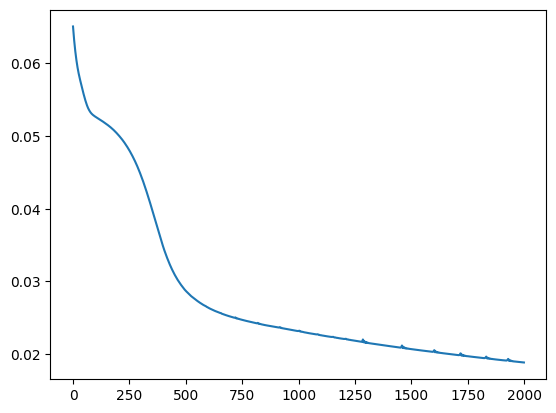

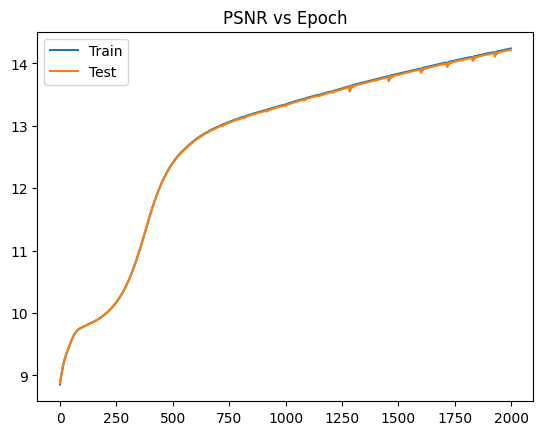

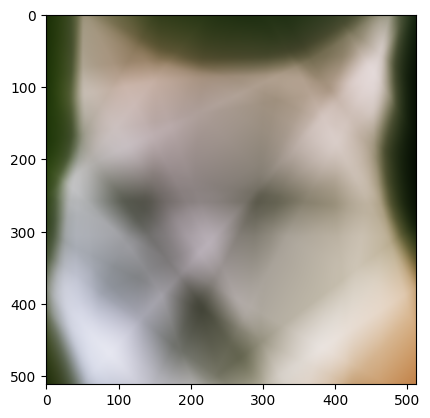

In [4]:
epoch_count = 2000

class NeuralNetwork(nn.Module):
    def __init__(self, input_dim=2, output_dim=3):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, 256)
        self.layer4 = nn.Linear(256, output_dim)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.relu(self.layer3(x))
        x = torch.sigmoid(self.layer4(x))
        return x

model = NeuralNetwork().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_function = torch.nn.MSELoss()

def calculate_psnr(prediction, target):
    return -10 * torch.log10(2.0 * loss_function(prediction, target))

def train_model():
    model.train()
    predictions = []
    train_psnr_values = []
    test_psnr_values = []
    loss_values = []

    for epoch in range(epoch_count):
        optimizer.zero_grad()
        train_prediction = model(train_input)
        loss = loss_function(train_output, train_prediction)

        loss.backward()
        loss_values.append(loss.item())
        optimizer.step()

        with torch.no_grad():
            train_psnr_values.append(calculate_psnr(train_prediction, train_output).cpu().numpy())
            test_prediction = model(test_input)
            test_psnr_values.append(calculate_psnr(test_prediction, test_output).cpu().numpy())
            predicted_image = test_prediction.reshape(512, 512, 3).cpu().numpy()
            predictions.append(predicted_image)

        if (epoch) % 100 == 0:
            print(f"Epoch: {epoch + 1} | Loss: {loss.item()} | Train PSNR: {train_psnr_values[-1]} | Test PSNR: {test_psnr_values[-1]}")

    print()
    return predictions, train_psnr_values, test_psnr_values, loss_values

predictions, train_psnr_values, test_psnr_values, loss_values = train_model()

import numpy as np
best_index = np.argmax(test_psnr_values)
best_prediction = predictions[best_index]

plt.plot(loss_values)
plt.show()

plt.plot(train_psnr_values, label='Train')
plt.plot(test_psnr_values, label='Test')
plt.title('PSNR vs Epoch')
plt.legend()
plt.show()

plt.imshow(best_prediction)
plt.show()

## Fourier Feature MLP

Epoch: 1 | Loss: 0.06563129276037216 | Train PSNR: 8.81859016418457 | Test PSNR: 8.83496379852295
Epoch: 101 | Loss: 0.014695147052407265 | Train PSNR: 15.317960739135742 | Test PSNR: 15.405939102172852
Epoch: 201 | Loss: 0.0061801522970199585 | Train PSNR: 19.079708099365234 | Test PSNR: 18.917327880859375
Epoch: 301 | Loss: 0.004920824896544218 | Train PSNR: 20.069320678710938 | Test PSNR: 19.74753189086914
Epoch: 401 | Loss: 0.004198530688881874 | Train PSNR: 20.758726119995117 | Test PSNR: 20.231962203979492
Epoch: 501 | Loss: 0.0035807667300105095 | Train PSNR: 21.449939727783203 | Test PSNR: 20.62955093383789
Epoch: 601 | Loss: 0.0029976111836731434 | Train PSNR: 22.221946716308594 | Test PSNR: 20.98226547241211
Epoch: 701 | Loss: 0.0025084931403398514 | Train PSNR: 22.995569229125977 | Test PSNR: 21.26309585571289
Epoch: 801 | Loss: 0.002133535221219063 | Train PSNR: 23.698701858520508 | Test PSNR: 21.44365119934082
Epoch: 901 | Loss: 0.0018242178484797478 | Train PSNR: 24.37893

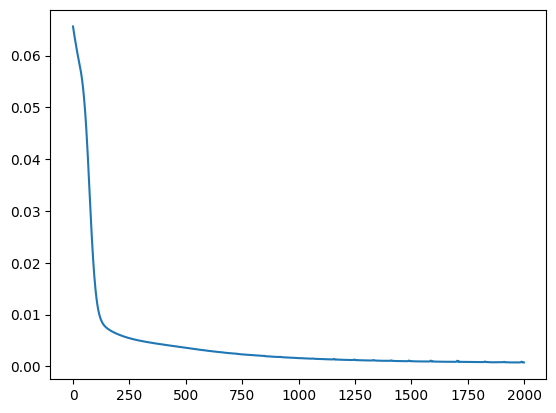

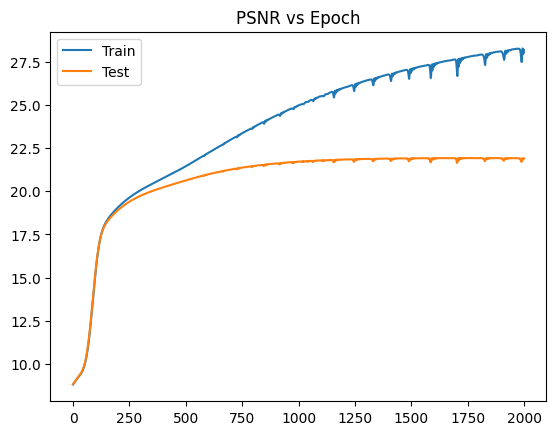

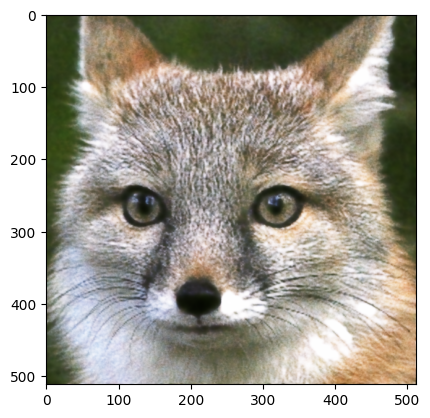

In [ ]:

class FourierFeatureMLP(NeuralNetwork):
    def __init__(self, output_dim=3, feature_dim=256, scale=10):
        super().__init__(input_dim=2 * feature_dim, output_dim=output_dim)
        self.B = scale * torch.randn((feature_dim, 2)).to(DEVICE)

    def forward(self, x):
        x = 2 * torch.pi * x @ self.B.T
        x = torch.cat([torch.sin(x), torch.cos(x)], axis=1)
        return super().forward(x)

model = FourierFeatureMLP().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_function = torch.nn.MSELoss()

checkpoint_interval = 100

def train_model():
    model.train()
    predictions = []
    train_psnr_values = []
    test_psnr_values = []
    loss_values = []

    for epoch in range(epoch_count):
        optimizer.zero_grad()
        train_prediction = model(train_input)
        loss = loss_function(train_output, train_prediction)

        loss.backward()
        loss_values.append(loss.item())
        optimizer.step()

        with torch.no_grad():
            train_psnr_values.append(calculate_psnr(train_prediction, train_output).cpu().numpy())
            test_prediction = model(test_input)
            test_psnr_values.append(calculate_psnr(test_prediction, test_output).cpu().numpy())
            predicted_image = test_prediction.reshape(512, 512, 3).cpu().numpy()

            if (epoch) % checkpoint_interval == 0:
                predictions.append(predicted_image)
                print(f"Epoch: {epoch + 1} | Loss: {loss.item()} | Train PSNR: {train_psnr_values[-1]} | Test PSNR: {test_psnr_values[-1]}")

    print()
    return predictions, train_psnr_values, test_psnr_values, loss_values

predictions, train_psnr_values, test_psnr_values, loss_values = train_model()

best_index = np.argmax(test_psnr_values)
best_prediction = predictions[best_index // checkpoint_interval]

plt.plot(loss_values)
plt.show()

plt.plot(train_psnr_values, label='Train')
plt.plot(test_psnr_values, label='Test')
plt.title('PSNR vs Epoch')
plt.legend()
plt.show()

plt.imshow(best_prediction)
plt.show()

Epoch: 1 | Loss: 0.0659080445766449 | Train PSNR: 8.80031681060791 | Test PSNR: 8.833196640014648
Epoch: 101 | Loss: 0.021833911538124084 | Train PSNR: 13.598384857177734 | Test PSNR: 13.615394592285156
Epoch: 201 | Loss: 0.012812870554625988 | Train PSNR: 15.913236618041992 | Test PSNR: 15.901774406433105
Epoch: 301 | Loss: 0.010277639143168926 | Train PSNR: 16.87076759338379 | Test PSNR: 16.84734535217285
Epoch: 401 | Loss: 0.0093081034719944 | Train PSNR: 17.301088333129883 | Test PSNR: 17.279499053955078
Epoch: 501 | Loss: 0.008759213611483574 | Train PSNR: 17.565048217773438 | Test PSNR: 17.524940490722656
Epoch: 601 | Loss: 0.008441537618637085 | Train PSNR: 17.72548484802246 | Test PSNR: 17.68135643005371
Epoch: 701 | Loss: 0.008690549060702324 | Train PSNR: 17.599227905273438 | Test PSNR: 17.5631160736084
Epoch: 801 | Loss: 0.008084719069302082 | Train PSNR: 17.91305160522461 | Test PSNR: 17.860919952392578
Epoch: 901 | Loss: 0.007961473427712917 | Train PSNR: 17.97976684570312

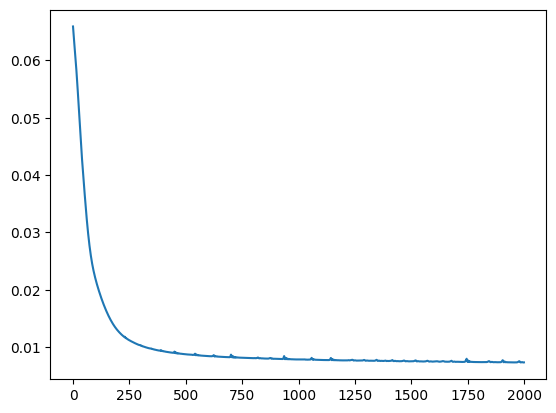

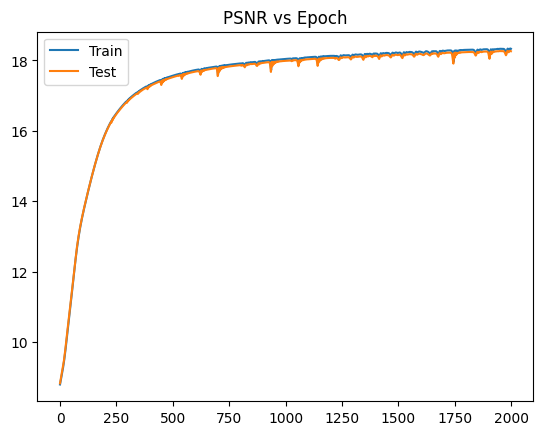

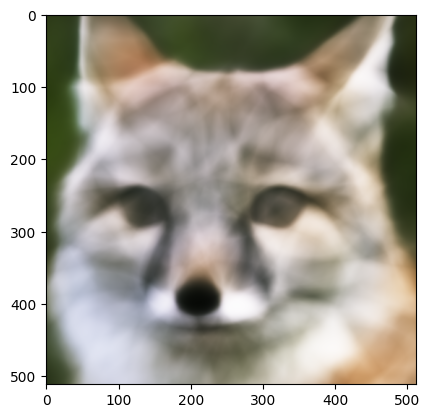

Epoch: 1 | Loss: 0.0651588961482048 | Train PSNR: 8.849963188171387 | Test PSNR: 8.865257263183594
Epoch: 101 | Loss: 0.016812197864055634 | Train PSNR: 14.7334566116333 | Test PSNR: 14.85625171661377
Epoch: 201 | Loss: 0.006072619464248419 | Train PSNR: 19.15593910217285 | Test PSNR: 18.99532699584961
Epoch: 301 | Loss: 0.004966099746525288 | Train PSNR: 20.029544830322266 | Test PSNR: 19.71590232849121
Epoch: 401 | Loss: 0.0042961775325238705 | Train PSNR: 20.658878326416016 | Test PSNR: 20.154788970947266
Epoch: 501 | Loss: 0.003678757231682539 | Train PSNR: 21.332687377929688 | Test PSNR: 20.544517517089844
Epoch: 601 | Loss: 0.003114529652521014 | Train PSNR: 22.055776596069336 | Test PSNR: 20.87864112854004
Epoch: 701 | Loss: 0.002651610877364874 | Train PSNR: 22.754602432250977 | Test PSNR: 21.156970977783203
Epoch: 801 | Loss: 0.002272979589179158 | Train PSNR: 23.42374610900879 | Test PSNR: 21.36380386352539
Epoch: 901 | Loss: 0.001980308210477233 | Train PSNR: 24.022373199462

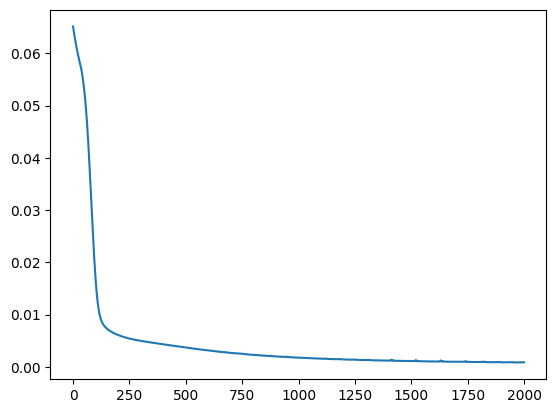

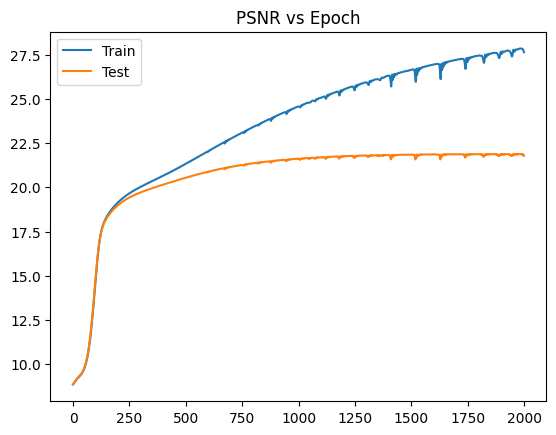

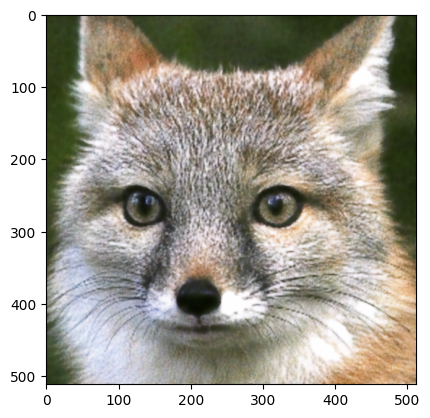

Epoch: 1 | Loss: 0.06542012095451355 | Train PSNR: 8.832586288452148 | Test PSNR: 8.846017837524414
Epoch: 101 | Loss: 0.05952765792608261 | Train PSNR: 9.242512702941895 | Test PSNR: 9.174915313720703
Epoch: 201 | Loss: 0.022053977474570274 | Train PSNR: 13.554831504821777 | Test PSNR: 9.331231117248535
Epoch: 301 | Loss: 0.004657489713281393 | Train PSNR: 20.308181762695312 | Test PSNR: 8.500935554504395
Epoch: 401 | Loss: 0.0025875838473439217 | Train PSNR: 22.860755920410156 | Test PSNR: 8.19189167022705
Epoch: 501 | Loss: 0.0021171895787119865 | Train PSNR: 23.732101440429688 | Test PSNR: 8.063153266906738
Epoch: 601 | Loss: 0.0019299034029245377 | Train PSNR: 24.13434600830078 | Test PSNR: 7.985934257507324
Epoch: 701 | Loss: 0.0018309270963072777 | Train PSNR: 24.362991333007812 | Test PSNR: 7.935795307159424
Epoch: 801 | Loss: 0.0017677515279501677 | Train PSNR: 24.515487670898438 | Test PSNR: 7.899225234985352
Epoch: 901 | Loss: 0.001730691408738494 | Train PSNR: 24.6075038909

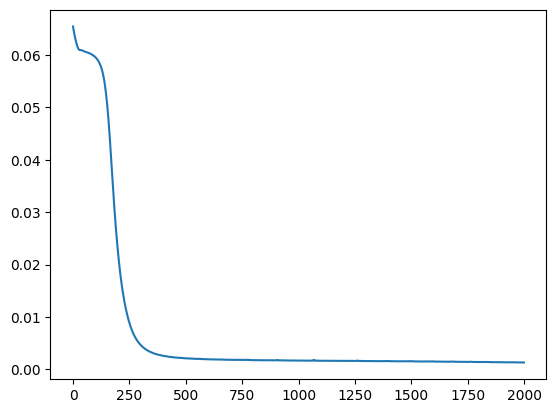

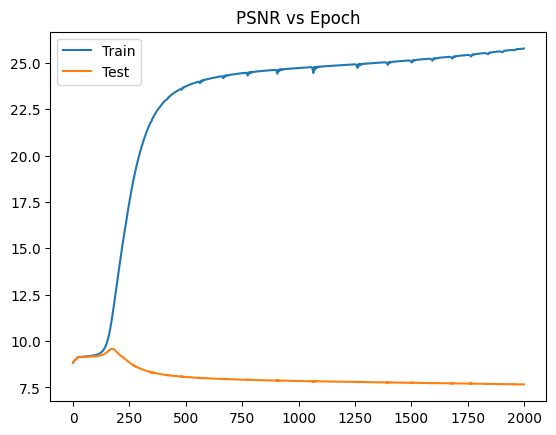

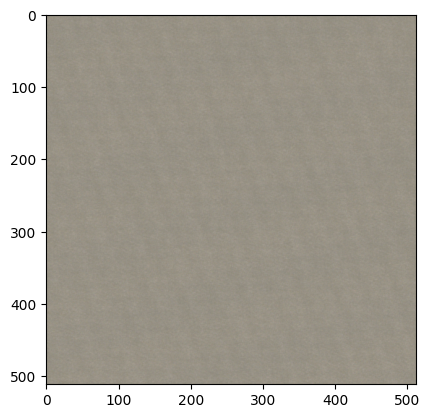

Optimal scale = 10


In [6]:
results = []

for scale in [1, 10, 100]:
    model = FourierFeatureMLP(scale=scale).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    loss_function = torch.nn.MSELoss()

    def train_model():
        model.train()
        predictions = []
        train_psnr_values = []
        test_psnr_values = []
        loss_values = []

        for epoch in range(epoch_count):
            optimizer.zero_grad()
            train_prediction = model(train_input)
            loss = loss_function(train_output, train_prediction)

            loss.backward()
            loss_values.append(loss.item())
            optimizer.step()

            with torch.no_grad():
                train_psnr_values.append(calculate_psnr(train_prediction, train_output).cpu().numpy())
                test_prediction = model(test_input)
                test_psnr_values.append(calculate_psnr(test_prediction, test_output).cpu().numpy())
                predicted_image = test_prediction.reshape(512, 512, 3).cpu().numpy()

                if (epoch) % checkpoint_interval == 0:
                    predictions.append(predicted_image)
                    print(f"Epoch: {epoch + 1} | Loss: {loss.item()} | Train PSNR: {train_psnr_values[-1]} | Test PSNR: {test_psnr_values[-1]}")

        print()
        return predictions, train_psnr_values, test_psnr_values, loss_values

    predictions, train_psnr_values, test_psnr_values, loss_values = train_model()

    results.append(max(test_psnr_values))

    best_index = np.argmax(test_psnr_values)
    best_prediction = predictions[best_index // checkpoint_interval]

    plt.plot(loss_values)
    plt.show()

    plt.plot(train_psnr_values, label='Train')
    plt.plot(test_psnr_values, label='Test')
    plt.title('PSNR vs Epoch')
    plt.legend()
    plt.show()

    plt.imshow(best_prediction)
    plt.show()

print(f"Optimal scale = {[1, 10, 100][np.argmax(results)]}")